In [1]:
import numpy as np
import xsimlab as xs

In [2]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [3]:
print('xarray-simlab version: ', xs.__version__)
print('phydra version: ', phydra.__version__)

xarray-simlab version:  0.4.1
phydra version:  0+untagged.43.g53b8490.dirty


In [4]:
from phydra.models import GridXY_NP_Chemostat_model

In [5]:
GridXY_NP_Chemostat_model

<xsimlab.Model (10 processes, 13 inputs)>
Grid
    y_label           [in]
    x_label           [in]
    x_dim             [in] length of dimension, x direction
    y_dim             [in] length of dimension, y direction
Env
    Env_dim           [in]
    dim_label         [in]
MS
    P_num             [in]
    P_initval         [in] () or ('P',) 
    N_initval         [in] () or ('N',) 
GX
    exchange_rate     [in]
NP_uptake
FX
Mix
    flowrate          [in]
N
    dim_label         [in]
P_Mortality
P
    dim_label         [in]

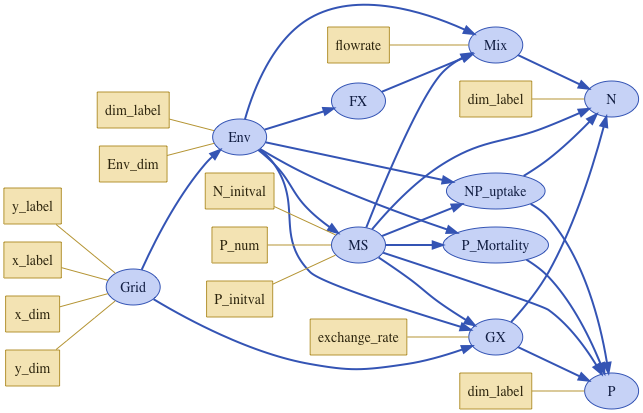

In [6]:
GridXY_NP_Chemostat_model.visualize(show_inputs=True)

# supply time, parameters and output

this model allows any number of phytoplankton types (or size classes) to be initialized within each cell. For simplicity "P_num" is 1 here:

In [9]:
in_ds = xs.create_setup(
    model=GridXY_NP_Chemostat_model,
    clocks={   
        'time': np.linspace(0,30,1000),
    },
    master_clock='time',
    input_vars={
        'Grid__x_dim':100,
        'Grid__y_dim':100,
        
        'MS':{
            'N_initval':0.01,
            'P_num':1,
            'P_initval':.1
        },
        
        'Mix__flowrate':1.,
        
        'GX__exchange_rate':1.5
        
    },
    output_vars={
        # state of components as output
        'N__state':'time',
        'P__state':'time',
        
        # fluxes stored for diagnostic purposes
        'Mix__N_input':'time'
    }
)

# Model Run

In [10]:
from xsimlab.monitoring import ProgressBar

with ProgressBar(frontend='console'):
    with GridXY_NP_Chemostat_model:
        out_ds = in_ds.xsimlab.run()

██████████ 100% | Simulation finished in 00:37 


In [15]:
out_ds

<xarray.Dataset>
Dimensions:            (Env: 1, N: 1, P: 1, time: 1000, x: 100, y: 100)
Coordinates:
  * Env                (Env) int64 1
  * N                  (N) int64 0
  * P                  (P) int64 0
  * time               (time) float64 0.0 0.03003 0.06006 ... 29.94 29.97 30.0
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    Env__Env_dim       int64 1
    Env__dim_label     <U3 'Env'
    GX__exchange_rate  float64 1.5
    Grid__x_dim        int64 100
    Grid__x_label      <U1 'x'
    Grid__y_dim        int64 100
    Grid__y_label      <U1 'y'
    MS__N_initval      float64 0.01
    MS__P_initval      float64 0.1
    MS__P_num          int64 1
    Mix__N_input       (time, x, y, Env, N) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Mix__flowrate      float64 1.0
    N__dim_label       <U1 'N'
    N__state           (time, x, y, Env, N) float64 0.01 0.01 ... 0.001594
    P__dim_label       <U1 'P'
    P__state           (time, x, y, Env, P) float64 0.1 0.1 ... 0.08293 0.08293

# Model output

below the 2d grid of our model is plotted, with the 'time' that can be controlled via the slider next to it

In [16]:
import hvplot.xarray
import holoviews as hv

import matplotlib.pyplot as plt

## Nutrient

The nutrient has a small square influx in the middle of the grid, over time the first influx of nutrients is taken up by phytoplankton that consumes it, reaching a steady state quickly.

In [17]:
N_out = out_ds.N__state.hvplot.image(
    x='x', y='y', clim=(0, 5),
    width=550, height=550,
    cmap=plt.cm.viridis, groupby='time'
)

N_out

:DynamicMap   [time]
   :Image   [x,y]   (N__state)

## Phytoplankton

There is a small concentration of nutrient and phytoplankton initializedin each cell, that fuels a short growth across the grid. Additional nutrients flowing in at the middle are advected towards edges creating a gradient in phytoplankton biomass.

In [20]:
P_out = out_ds.P__state.hvplot.image(
    x='x', y='y', clim=(0, 5),
    width=550, height=550,
    cmap=plt.cm.viridis, groupby='time'
)

P_out

:DynamicMap   [time]
   :Image   [x,y]   (P__state)

## Nutrient input (as a model diagnostic)

In [21]:
N_in = out_ds.Mix__N_input.hvplot.image(
    x='x', y='y', clim=(0, 5),
    width=550, height=550,
    cmap=plt.cm.viridis, groupby='time'
)

N_in

:DynamicMap   [time]
   :Image   [x,y]   (Mix__N_input)